In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:

downloaded = drive.CreateFile({'id':'1-Pi2LI3msqoA1FliwDTi_8DaaHwimqQC'}) # replace the id with id of file you want to access
downloaded.GetContentFile('KSC.mat')

In [ ]:
downloaded1 = drive.CreateFile({'id':'1F8lSkh3zoh8oGFWmigqh62jf70xkFJCG'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('KSC_gt.mat')

In [ ]:
%load_ext tensorboard
import datetime, os

In [ ]:
!pip install -q keras
!pip install h5py ppyaml
!pip install spectral
import spectral

ERROR: Could not find a version that satisfies the requirement ppyaml (from versions: none)
ERROR: No matching distribution found for ppyaml
     |████████████████████████████████| 215kB 5.5MB/s 


In [ ]:

from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import seaborn as sn
import keras
from sklearn.utils import class_weight
from keras import backend as A
from keras.backend import sigmoid
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.layers import BatchNormalization,Dense, Dropout, Activation, Flatten, Conv2D , Conv3D,MaxPooling2D, Reshape,Input,MaxPooling3D,Conv1D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils.generic_utils import get_custom_objects
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
m = loadmat('KSC.mat')
gt= loadmat('KSC_gt.mat')
print(m.keys())
print(gt.keys())

2.4.0
dict_keys(['__header__', '__version__', '__globals__', 'KSC'])
dict_keys(['__header__', '__version__', '__globals__', 'KSC_gt'])


In [ ]:
m['KSC'].shape
gt['KSC_gt'].shape
a=m['KSC']
print(a.shape)
groundtruth=gt['KSC_gt']
print(groundtruth.shape)
d=[]
temp=[]
gth=[]

(512, 614, 176)
(512, 614)


In [ ]:
for j in range(512):                                 # 3d image to 2d image columns= Bands rows = pixel
    for k in range(614):
        temp=a[j,k,:]
        d.append(temp)

In [ ]:
for l in range(512):                                # 2d image of ground truth to 1 d image with single column (target)
    for s in range(614):
        gtemp=groundtruth[l,s]
        gth.append(gtemp)

In [ ]:
Img_target=pd.DataFrame(gth,columns=['target'])
targetclasssamples=Img_target['target'].value_counts()
tq=pd.DataFrame(targetclasssamples)
tq

,target
0,309157
13,927
1,761
9,520
12,503
8,431
11,419
10,404
3,256
4,252


In [ ]:
Img_features=pd.DataFrame(d)
from sklearn.preprocessing import StandardScaler     # code for PCA while using scaling
#from sklearn.preprocessing import MinMaxScaler
scaler=StandardScaler()
#scaler=MinMaxScaler((-0.5,0.5))
scaler.fit(Img_features)
scaled_data=scaler.transform(Img_features)
Img_feature_scaled=pd.DataFrame(scaled_data)
print(scaled_data.shape)
Img_feature_scaled.head(5)

(314368, 176)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175
0,-0.150595,-0.512081,-0.078150,-0.028519,-0.597387,-0.421616,-0.385050,-0.278524,-0.190040,-0.145990,-0.120404,-0.061566,0.040374,0.115593,0.096897,0.144657,0.070483,0.019635,0.043065,0.056913,0.118609,0.072602,0.138181,0.159558,0.119938,0.144715,0.139276,0.179864,0.199204,0.222347,0.285957,0.345325,0.578530,0.735998,0.844114,0.890127,0.942512,0.920828,0.922117,0.929782,...,-0.064352,-0.045921,-0.060034,-0.067739,-0.057954,-0.050325,-0.050346,-0.049237,-0.043080,-0.033127,-0.042435,-0.035593,-0.045520,-0.034335,-0.039067,-0.020848,-0.038101,-0.026404,-0.022064,-0.048072,-0.049034,-0.059682,-0.061505,-0.081958,-0.074012,-0.078594,-0.070513,-0.080835,-0.070239,-0.066579,-0.070182,-0.094691,-0.072993,-0.095777,-0.104324,-0.082610,-0.089427,-0.152843,-0.112849,-0.145075
1,-0.151323,-0.745358,-0.154348,-0.046180,-1.074386,-0.978712,-0.775030,-0.691885,-0.674380,-0.565672,-0.521417,-0.500192,-0.457551,-0.364119,-0.301715,-0.351637,-0.389254,-0.438962,-0.433632,-0.479218,-0.428080,-0.440177,-0.431114,-0.399391,-0.389496,-0.391305,-0.411348,-0.397899,-0.387551,-0.417190,-0.345524,-0.246946,-0.017248,0.282042,0.493604,0.669474,0.720312,0.763848,0.744910,0.763712,...,-0.070022,-0.055166,-0.066120,-0.074767,-0.065024,-0.060221,-0.059764,-0.058717,-0.053004,-0.044314,-0.052158,-0.045269,-0.055203,-0.046781,-0.049348,-0.032320,-0.048860,-0.040854,-0.035543,-0.056431,-0.056610,-0.067276,-0.067624,-0.087087,-0.078663,-0.082484,-0.076768,-0.086589,-0.075716,-0.073396,-0.075113,-0.099080,-0.078946,-0.098888,-0.108069,-0.087396,-0.092110,-0.155371,-0.115533,-0.146667
2,-0.151115,-1.095274,-0.162814,-0.046180,-1.021386,-0.928067,-0.921272,-0.783743,-0.718411,-0.691576,-0.601620,-0.579942,-0.534155,-0.474822,-0.482902,-0.493435,-0.495347,-0.544792,-0.569831,-0.546235,-0.492396,-0.472226,-0.525997,-0.492549,-0.479396,-0.480642,-0.440328,-0.455675,-0.534240,-0.533470,-0.517746,-0.472573,-0.215841,0.055064,0.283298,0.478241,0.576536,0.631019,0.567703,0.597643,...,-0.068278,-0.052645,-0.064013,-0.073527,-0.063610,-0.057617,-0.056887,-0.057664,-0.050085,-0.041168,-0.049212,-0.042266,-0.051053,-0.043833,-0.046022,-0.028790,-0.044557,-0.036408,-0.031459,-0.052386,-0.052822,-0.063824,-0.066491,-0.085319,-0.077500,-0.081928,-0.075154,-0.084431,-0.074499,-0.069775,-0.072647,-0.097669,-0.073985,-0.098110,-0.105909,-0.084560,-0.090098,-0.154359,-0.115130,-0.146030
3,-0.149763,-0.103845,-0.061217,-0.024594,-0.385388,-0.370971,-0.238808,-0.094808,-0.057947,0.063851,0.080103,0.058059,0.078676,0.152494,0.169371,0.215556,0.176576,0.160742,0.213314,0.224454,0.311558,0.361040,0.422829,0.407980,0.479537,0.502062,0.573979,0.584299,0.404568,0.425836,0.486882,0.514546,0.504058,0.509020,0.546180,0.537082,0.498113,0.510265,0.529730,0.502746,...,-0.052792,-0.032195,-0.046692,-0.057405,-0.046171,-0.038346,-0.037527,-0.038177,-0.028777,-0.013899,-0.026231,-0.015907,-0.031134,-0.015993,-0.020621,0.007389,-0.019658,-0.004544,-0.000415,-0.031086,-0.032801,-0.047946,-0.050626,-0.073469,-0.065096,-0.071742,-0.061432,-0.073283,-0.062328,-0.057207,-0.061552,-0.088265,-0.064857,-0.088312,-0.097555,-0.075343,-0.080538,-0.148799,-0.106273,-0.141784
4,-0.149971,0.246071,0.023447,-0.004969,0.197610,0.287415,0.297414,0.456340,0.514456,0.525501,0.681623,0.775809,0.844715,0.890512,0.930357,0.924548,0.919227,0.901552,0.962409,0.995144,1.051196,1.066112,1.118634,1.122192,1.198737,1.216756,1.240524,1.277615,1.314039,1.297931,1.319288,1.473461,1.521845,1.520104,1.439981,1.346145,1.295417,1.258939,1.263875,1.250058,...,-0.041233,-0.019028,-0.034520,-0.046450,-0.032503,-0.022721,-0.021830,-0.021850,-0.010096,0.007777,-0.007374,0.003445,-0.012598,0.004642,-0.002477,0.036068,0.000323,0.019910,0.029812,-0.015987,-0.017651,-0.0

In [ ]:
from sklearn.decomposition import PCA              # Applying PCA and obtainng variance in different PC bands.
bands=15
pca=PCA(n_components=bands)
pca.fit(scaled_data)     # scaled Image
#pca.fit(Img_features)     #original without scaling
pca_image=pca.transform(scaled_data)
#pca_image=pca.transform(Img_features)
variance=pca.explained_variance_ratio_
print(variance)
print("___________________________________________")
print(pca.singular_values_)

[0.2870401  0.11563006 0.10909688 0.04017486 0.02489982 0.01218961
 0.00936347 0.00910299 0.00822749 0.0068597  0.00650285 0.00595623
 0.00575095 0.00574214 0.00554059]
___________________________________________
[3985.16940157 2529.36131807 2456.86713901 1490.91425485 1173.74461099
  821.24044408  719.77026612  709.68807156  674.69742661  616.06726462
  599.82904289  574.06542632  564.08607333  563.65371596  553.67325228]


In [ ]:
Frame_pca_image=pd.DataFrame(pca_image)
Frame_pca_image.head(5)
print(Frame_pca_image.shape)
PCAband=[]                   #converting 2D PCA matrix to 3D with bands=components
#PCAbandFinal=[]
bandtemp=[]
#for m in range(pca_image.shape[1]):
for s in range(512):
        bandtemp=pca_image[s*614:(s+1)*614]
        PCAband.append(bandtemp)
    #PCAbandFinal.append(PCAband)
PCAbandFinalarray=np.asarray(PCAband)   # converting the 3D list as array.
print(PCAbandFinalarray.shape)
PCAbandFinalarray[1,1,1]

(314368, 15)
(512, 614, 15)


3.2443432625594837

In [ ]:
def padWithZeros(X, margin=2):    # Padding the image with zeroes and is dedendent on the window or patch size
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):  #creating image patches with window size.
    margin = int((windowSize - 1) / 2)
    print(margin)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    print(X.shape[0] * X.shape[1])
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
Feature_Image, Target = createImageCubes(PCAbandFinalarray, groundtruth, windowSize=25)
print(Feature_Image.shape)
print(Target.shape)

12
314368
(5211, 25, 25, 15)
(5211,)


In [ ]:

from sklearn.model_selection import train_test_split
trainsize=10
testsize= ((100-trainsize)/100)
print(testsize)
Feature_Image1,Target1 = shuffle(Feature_Image,Target)
x_train, x_test, y_train, y_test = train_test_split(Feature_Image1,Target1,test_size=testsize,stratify=Target1)
#x_train, x_test, y_train, y_test = train_test_split(Feature_Image,Target,test_size=testsize,stratify=Target)
YtrainFrame=pd.DataFrame(y_train,columns=['target'])
y=YtrainFrame['target']
z=y.value_counts(ascending=True)
yq=pd.DataFrame(z)
print("Final Training Samples ", yq )

0.9
Final Training Samples        target
6.0       11
4.0       16
5.0       23
1.0       24
3.0       25
2.0       26
9.0       40
10.0      42
7.0       43
11.0      50
8.0       52
0.0       76
12.0      93


In [ ]:
windowSize=25
K=bands   # Number of PCA bands
x_train = x_train.reshape(-1, windowSize, windowSize, K, 1)
x_train.shape

(521, 25, 25, 15, 1)

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_train.shape

(521, 13)

In [ ]:
x_test = x_test.reshape(-1, windowSize, windowSize, K, 1)
print(x_test.shape)
y_test=np_utils.to_categorical(y_test)
print(y_test.shape)

(4690, 25, 25, 15, 1)
(4690, 13)


In [ ]:
model=Sequential()
conv3D_1=Conv3D(40,(7,7,7),padding='valid',input_shape=(windowSize,windowSize,K,1))
conv3D_1r=conv3D_1
model.add(conv3D_1r)
model.add(Activation('relu'))
print(conv3D_1r.output_shape)
conv3D_2=Conv3D(40,(3,3,3))
conv3D_2r=conv3D_2
model.add(conv3D_2r)
model.add(Activation('relu'))
c=conv3D_2r.output_shape # Getting output shape of the layer
print(c)
reshape3D_4r = Reshape((c[1], c[2], c[3]*c[4])) # Reshape Layer for 3D to 2D
model.add(reshape3D_4r)

print(reshape3D_4r.output_shape)
#-----Convolution 2D Layer
conv2D_1=Conv2D(filters=32, kernel_size=(4,4))
conv2D_1r=conv2D_1
model.add(conv2D_1r)
model.add(Activation('relu'))
#odel.add(MaxPooling2D(pool_size=(2,2)))
conv2D_2=Conv2D(filters=64, kernel_size=(3,3))
conv2D_2r=conv2D_2
model.add(conv2D_2r)
model.add(Activation('relu'))
x=conv2D_2r.output_shape # Getting output shape of the layer
print(x)
reshape1D= Reshape((x[1],x[2]*x[3]))
model.add(reshape1D)
print(reshape1D.output_shape)
con1D=Conv1D(filters=62, kernel_size=(5))
con1D1r=con1D
model.add(con1D1r)
model.add(Activation('relu'))
model.add(Flatten())
D1=Dense(units=256)
D2=Dense(units=128)
D1r=D1
D2r=D2
model.add(D1r)
model.add(Dropout(0.4))
model.add(D2r)
model.add(Activation('relu'))
model.add(Dropout(0.4))
output_units=13
model.add(Dense(units=output_units, activation='softmax'))

(None, 19, 19, 9, 40)
(None, 17, 17, 7, 40)
(None, 17, 17, 280)
(None, 12, 12, 64)
(None, 12, 768)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 19, 19, 9, 40)     13760     
_________________________________________________________________
activation_6 (Activation)    (None, 19, 19, 9, 40)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 17, 17, 7, 40)     43240     
_________________________________________________________________
activation_7 (Activation)    (None, 17, 17, 7, 40)     0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 17, 17, 280)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        143392    
_________________________________________________________________
activation_8 (Activation)    (None, 14, 14, 32)       

In [ ]:
Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])



In [ ]:
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs', histogram_freq=1)

In [ ]:
filepath = "bestmodel.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
#history=model.fit(x_train, y_train, batch_size=200, epochs=250, validation_split=0.0, verbose=1, callbacks=[tensorboard_callback,checkpoint])
history=model.fit(x_train, y_train, batch_size=200, epochs=250, validation_split=0.0, verbose=1, callbacks=callbacks_list)

Epoch 1/250
3/3 [==============================] - 1s 68ms/step - loss: 2.5380 - accuracy: 0.1105

Epoch 00001: loss improved from inf to 2.51793, saving model to bestmodel.hdf5
Epoch 2/250
3/3 [==============================] - 0s 53ms/step - loss: 2.1058 - accuracy: 0.2994

Epoch 00002: loss improved from 2.51793 to 2.06197, saving model to bestmodel.hdf5
Epoch 3/250
3/3 [==============================] - 0s 54ms/step - loss: 1.7428 - accuracy: 0.3814

Epoch 00003: loss improved from 2.06197 to 1.72146, saving model to bestmodel.hdf5
Epoch 4/250
3/3 [==============================] - 0s 91ms/step - loss: 1.5082 - accuracy: 0.4616

Epoch 00004: loss improved from 1.72146 to 1.50650, saving model to bestmodel.hdf5
Epoch 5/250
3/3 [==============================] - 0s 54ms/step - loss: 1.3853 - accuracy: 0.5273

Epoch 00005: loss improved from 1.50650 to 1.34697, saving model to bestmodel.hdf5
Epoch 6/250
3/3 [==============================] - 0s 54ms/step - loss: 1.1578 - accuracy: 0.5

In [ ]:
model.load_weights("bestmodel.hdf5")               # loading weights from trained model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
#%tensorboard --logdir logs

In [ ]:
y_pred= model.predict(x_test)
y_pred= np.argmax(y_pred, axis=1)
classification = classification_report(np.argmax(y_test, axis=1), y_pred)
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       685
           1       1.00      0.97      0.98       219
           2       0.92      1.00      0.96       230
           3       1.00      0.91      0.95       227
           4       0.94      0.94      0.94       145
           5       0.98      0.98      0.98       206
           6       0.97      1.00      0.98        94
           7       1.00      1.00      1.00       388
           8       1.00      1.00      1.00       468
           9       1.00      0.99      0.99       364
          10       1.00      1.00      1.00       377
          11       0.98      1.00      0.99       453
          12       1.00      1.00      1.00       834

    accuracy                           0.99      4690
   macro avg       0.98      0.98      0.98      4690
weighted avg       0.99      0.99      0.99      4690



In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

131/131 [==============================] - 1s 8ms/step - loss: 0.0755 - accuracy: 0.9891
0.9897654584221749
0.9886054744742787
0.9835204025763233
[0.99561404 0.99530516 0.92       0.99519231 0.94482759 0.98058252
 0.96907216 1.         1.         1.         1.         0.98264642
 1.        ]


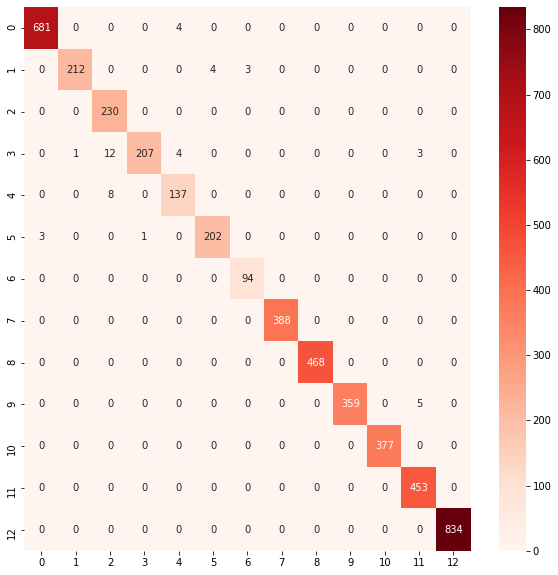

In [ ]:
oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
each_acc, aa = AA_andEachClassAccuracy(confusion)
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
score = model.evaluate(x_test, y_test, batch_size=36)
Test_Loss =  score[0]*100
Test_accuracy = score[1]*100
print(oa)
print(kappa)
print(aa)
#print (confusion)
a=confusion.diagonal()/confusion.sum(axis=0)
print(a)

plt.figure(figsize=(10,10))
sn.heatmap(confusion, annot=True, cmap=plt.cm.Reds,fmt="d")
plt.show()

In [ ]:
print(x_test[1].shape)
a=x_test[5].reshape(-1,25,25,15,1)
otest=x_test[5]

(25, 25, 15, 1)


In [ ]:
featuremap=actmodel.predict(a)
print (featuremap.shape)

NameError: ignored

Original Image


NameError: ignored

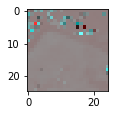

In [ ]:
print ('Original Image')
spectral.imshow(otest[:,:,:,0],(8,10,10),figsize=(1.5,1.5))
c=featuremap.reshape(25,25,15,1)
print ('Itermediate Model Image')
for i in range(32):
  select=c[:,:,:,i]
  spectral.imshow(select,(8,10,10),figsize=(1.5,1.5),fignum=i)

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

height = groundtruth.shape[0]
width = groundtruth.shape[1]
PATCH_SIZE = 25
numComponents = K
X = padWithZeros(PCAbandFinalarray, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputsRelu= np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(groundtruth[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            predictionrelu = (model.predict(X_test_image))
            predictionrelu = np.argmax(predictionrelu, axis=1)
            outputsRelu[i][j] = predictionrelu+1

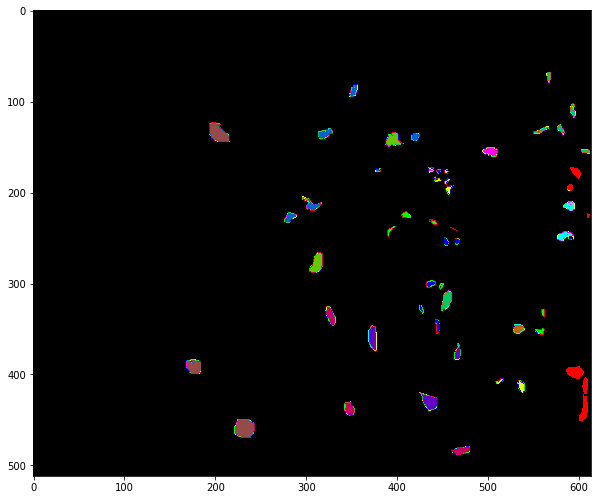

In [ ]:
predict_image = spectral.imshow(classes = outputsRelu.astype(int),figsize =(10,10))

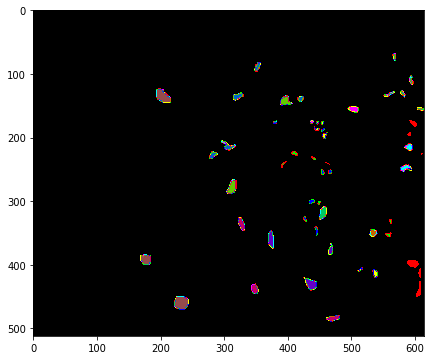

In [ ]:
ground_truth = spectral.imshow(classes = groundtruth,figsize =(7,7))

In [ ]:
filepath1 = "bestmodel_swish.hdf5"
checkpoint_swish = ModelCheckpoint(filepath1, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list_s= [checkpoint_swish]

In [ ]:
  logdir = os.path.join("logs1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir='./logs1', histogram_freq=1)

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history_swish.history['accuracy'])

#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Relu', 'Swish'], loc='upper left')
plt.show()
# "Loss"
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history_swish.history['loss'])

#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Relu', 'Swish'], loc='upper left')
plt.show()

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

height = groundtruth.shape[0]
width = groundtruth.shape[1]
PATCH_SIZE = 27
numComponents = K
X = padWithZeros(PCAbandFinalarray, PATCH_SIZE//2)

In [ ]:
outputsSwish= np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(groundtruth[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            predictionswish = (model_swish.predict(X_test_image))
            predictionswish = np.argmax(predictionswish, axis=1)
            outputsSwish[i][j] = predictionswish+1

In [ ]:
predict_image = spectral.imshow(classes = outputsSwish.astype(int),figsize =(10,10))

In [ ]:
predict_image = spectral.imshow(classes =groundtruth,figsize =(10,10))

In [ ]:
layer_outputs = [layer.output for layer in model_swish.layers ]
print (layer_outputs)

In [ ]:
actmodel1 = tf.keras.models.Model(inputs=model_swish.input,outputs=model_swish.get_layer('activation_1').output)

In [ ]:
b=x_test[5].reshape(-1,27,27,20,1)

In [ ]:
featuremap1=actmodel1.predict(b)
print (featuremap1.shape)

In [ ]:
print ('Original Image')
spectral.imshow(otest[:,:,:,0],(8,10,10))
b=featuremap1.reshape(21,21,16,32)
for i in range(32):
  select=b[:,:,:,i]
  spectral.imshow(select,(8,10,10),figsize=(1.5,1.5),fignum=i)